# Summary of Registered Entities and Companies in Kenya

Analyzing Business Registration Trends Across Political Transitions

Kabui, Charles  
2024-10-15

This analysis examines the patterns of business entity registrations in
Kenya from financial year 2015/2016 to 2024/2025, spanning two distinct
political eras. By visualizing data from the Business Registration
Service (BRS), we uncover intriguing trends in the formation of various
business entities, including private companies and business names, and
their potential correlation with political shifts in the country.

 *** 
[Read at <u>**ToKnow**</u>.ai](https://toknow.ai/posts/summary-of-registered-entities-and-companies-in-kenya/index.html) -- [Download as Notebook](https://toknow.ai/posts/summary-of-registered-entities-and-companies-in-kenya/index.output.ipynb) -- [Download as PDF](https://toknow.ai/posts/summary-of-registered-entities-and-companies-in-kenya/index.pdf)
 *** 

## Introduction

The business registration landscape of a country often serves as a
barometer for its economic health and entrepreneurial spirit. In Kenya,
a nation known for its dynamic economy and political atmosphere,
tracking these registrations can provide valuable insights into the
country’s economic trajectory and the impact of political transitions on
business confidence.

Since the post-election violence of 2007 that saw both the current
president (William Ruto) and his predecessor (Uhuru Kenyatta) defend
themselves at the Hague, there has always been a slowdown of the economy
around general elections. On the day of the election, the economy
literally stops, evidenced by closure of all businesses and related
activities such as delivery, money transfer, and investments. The
Nairobi Securities Exchange (NSE) also loses significant investments
during this time period. Open markets are often closed, public transport
is left scanty, and most people travel back to rural areas either to
vote or for security reasons. During this time, people want to know
their neighbors and have familiar faces around them. People often group
along tribal lines. During this frenzy atmosphere, people are often less
inclined to share personal information or opinions out loud.

This analysis delves into data from the Business Registration Service
(BRS)[1] of Kenya, covering a decade from financial year 2015/2016 to
2024/2025. This period is particularly interesting as it encompasses two
distinct political eras: the Uhuru Kenyatta/Jubilee Party era and the
William Ruto/UDA Party era. By examining the trends in business
registrations across these periods, we aim to uncover patterns that may
reflect the broader economic and political climate of Kenya.

## Methodology

Our analysis utilizes data scraped from the BRS website, focusing on
monthly registration figures for various types of business entities. The
data was processed and visualized using Python, with libraries such as
pandas for data manipulation and matplotlib for creating insightful
graphs.

The visualization process involved: 1. Aggregating monthly data across
multiple financial years 2. Plotting Total Registrations of Entities,
Year-over-Year Growth Rate of Business Entity Registrations and Trend,
Seasonality and Residuals 3. Marking significant political events, such
as the 2017 and 2022 elections

## Analysis

[1] <https://brs.go.ke/companies-registry-statistics/> -
[archive](https://web.archive.org/web/20241009120859/https://brs.go.ke/companies-registry-statistics/)

In [1]:
import sys
import os
from pathlib import Path

# Add root directory as python path
root_dir = os.path.abspath(Path(sys.executable).parents[2])
sys.path.append(root_dir)

%reload_ext autoreload
%autoreload 2

# Other imports
import pandas as pd
from playwright.async_api import Page
from python_utils.web_screenshot import web_screenshot_async
import io
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
from datetime import date, timedelta
from calendar import monthrange, month_abbr
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from typing import Callable
from statsmodels.tsa.seasonal import seasonal_decompose
import textwrap
from typing import Literal
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

Below is an image of the webpage we are going to crawl.

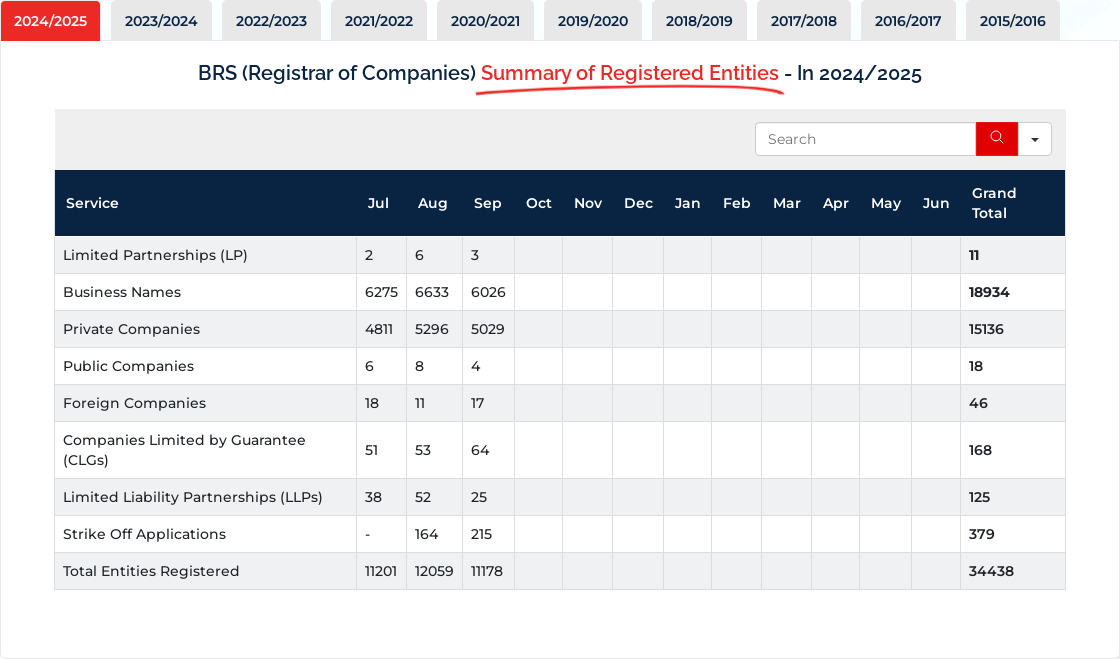

In [2]:
async def page_action_fn(page: Page):
    return await page.wait_for_selector(
        '.elementor-widget-container > [role="tablist"]')

# Take a screenshot
await web_screenshot_async(
    "https://brs.go.ke/companies-registry-statistics/",
    action = page_action_fn,
    width = 1200,
    height = 1200)

Below code crawls the webpage, and saves the records into a dataframe.

In [3]:
def get_date(month, year):
    # Convert month name to number
    month_num = [i.lower() for i in month_abbr].index(month.lower())
    # Get the last day of the month
    _, last_day = monthrange(int(year), month_num)
    return date(int(year), month_num, last_day)

def get_table(index: int):
    (finantial_year, table_str) = years_records[index]
    (finantial_year_1, finantial_year_2) = finantial_year.split('/')
    df = pd.read_html(io.StringIO(str(table_str)))[0]
    first_column = df.columns[0]
    # Remove last row (`Total Entities Registered`) and 
    # last column (`Grand Total`)
    df = df[df[first_column] != "Total Entities Registered"]\
        .drop("Grand Total", axis=1)
    # replace - with NaN
    df = df.replace("-", np.nan)
    df[first_column] = df[first_column].astype(str)
    for column in df.columns[1:]:
        df[column] = df[column].astype(float)
    indexes = [
        get_date(month, finantial_year_1) 
        for month 
        in df.columns[1:7]
    ] + [
        get_date(month, finantial_year_2) 
        for month 
        in df.columns[7:]
    ]
    df = df.set_index(first_column).T
    df.index = indexes
    df.columns = [i.lower().strip() for i in df.columns]
    return df

html: str = urlopen(
    "https://brs.go.ke/companies-registry-statistics/").read()
html_parser = BeautifulSoup(html, "html.parser").select_one(
    '.elementor-widget-container > [role="tablist"]')
years = { 
    i.attrs['data-tab']: i.get_text(separator='', strip=True) 
    for i 
    in html_parser.select(".ha-tabs__nav .ha-tab__title")
}
records = { 
    i.attrs['data-tab']: i.find('table') 
    for i 
    in html_parser.select('.ha-tabs__content [role="tabpanel"]') 
}
years_records = [(year, records[id]) for id, year in years.items()]

all_registrations = pd.concat([
    get_table(i) 
    for i 
    in range(len(years_records))
]).sort_index(ascending=True)
all_registrations.index = pd.to_datetime(all_registrations.index)
all_registrations

120 rows × 8 columns

### Registered Entities over Time

In [4]:
def draw_election_lines(
        start_date, end_date, ax: matplotlib.axes.Axes, election_dates_y):
    date_list = [
        min(start_date, date(2017, 1, 1)) + timedelta(days=x) 
        for x in range((end_date - start_date).days + 1)]
    # Add a vertical line at the split date
    election_date_2017 = date(2017, 8, 9)
    election_date_2022 = date(2022, 8, 9)
    ax.axvline(
        x=election_date_2017, color='green', linestyle='--', 
        linewidth=2, zorder=4)
    ax.axvline(
        x=election_date_2022, color='green', linestyle='--', 
        linewidth=2, zorder=4)
    # Fill the regions
    # Convert dates to matplotlib date format
    dates_mpl = mdates.date2num(date_list)
    split_date_mpl = mdates.date2num(election_date_2022)
    ax.fill_between(
        dates_mpl, 0, 100, where=dates_mpl < split_date_mpl, 
        facecolor='#f62f3c', alpha=0.08, transform=ax.get_xaxis_transform())
    ax.fill_between(
        dates_mpl, 0, 100, where=dates_mpl >= split_date_mpl,
        facecolor='#f8c811', alpha=0.08, transform=ax.get_xaxis_transform())
    ax.text(
        election_date_2017, election_dates_y[0], '2017 election', fontsize = 18, 
        rotation=90, zorder=6, ha='right')
    ax.text(
        election_date_2022, election_dates_y[1], '2022 election', fontsize = 18, 
        rotation=90, zorder=6, ha='right')

def plot_data(
        data_to_plot: pd.DataFrame | list[pd.DataFrame], title_1st_part: str,
        election_dates_y = (7200, 8500), legend_loc='upper left',
        axis_callback: Callable[[matplotlib.figure.Figure, matplotlib.axes.Axes], None] = None,
        ylabel = 'Registered Entities'):
    fig, ax = plt.subplots(figsize=(20, 10))
    data_to_plot: list[pd.DataFrame] = data_to_plot\
        if type(data_to_plot) == list else [data_to_plot]
    columns_used = [j for i in data_to_plot for j in i.columns]
    start_date = min(min(i.index.date) for i in data_to_plot)
    end_date = max(max(i.index.date) for i in data_to_plot)
    ax.set_title(
        f'{title_1st_part} ({start_date.strftime("%b %Y")} to {end_date.strftime("%b %Y")})', 
        fontsize = 24, pad = 45)
    if columns_used:
        ax.text(0.5,  1.03, 
            f'{", ".join(columns_used[:-1]) + " and " + columns_used[-1]}' 
                if len(columns_used) > 1  else columns_used[0], 
            transform=ax.transAxes, fontsize=14, ha='center',  style='italic')
    for subdata in data_to_plot:
        ax.plot(subdata.index, subdata.values, linewidth=4)
    ax.legend(columns_used, loc=legend_loc, fontsize=18)
    draw_election_lines(start_date, end_date, ax, election_dates_y)
    fig.text(0.72, 0.035, 'Ruto/UDA era', fontsize = 20, ha='left')
    fig.text(0.35, 0.035, 'Ruto/UDA era', fontsize = 20, ha='left')
    # Add a watermark to the center of the plot
    ax.text(1, 0.2, 'ToKnow.ai', ha='right', va='bottom', 
        fontsize=18, color='gray', alpha=0.5, transform=ax.transAxes, rotation=50)
    ax.set_xlabel('Years')
    ax.set_ylabel(ylabel)
    if axis_callback:
        axis_callback(fig, ax)

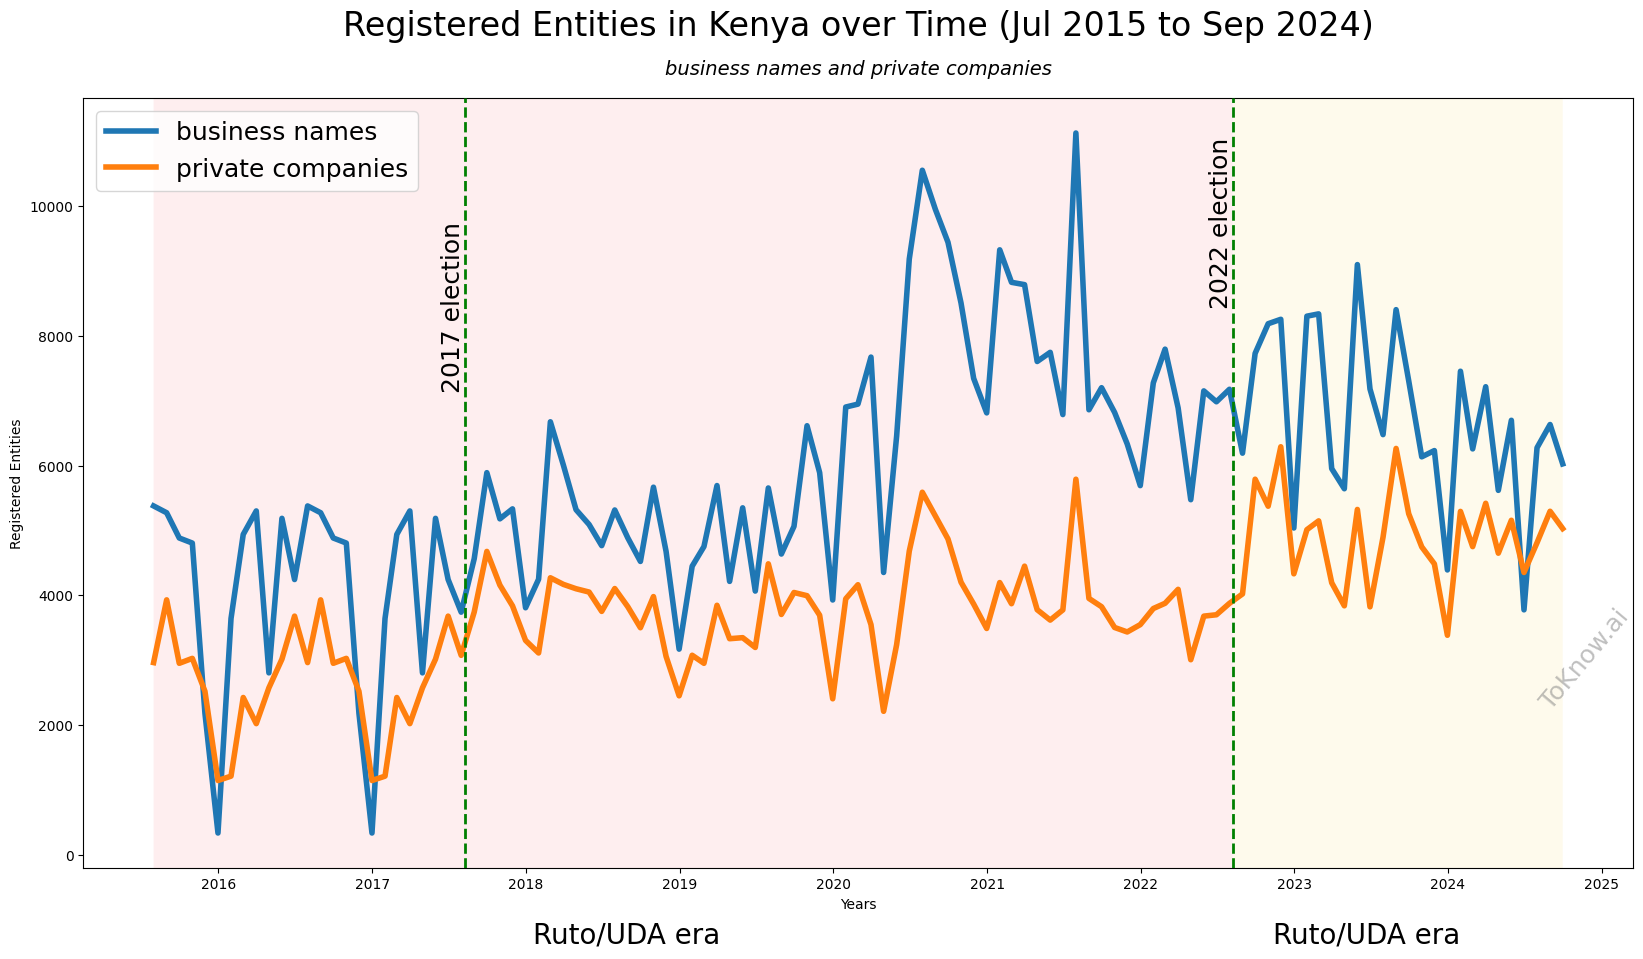

In [5]:
plot_columns = ['business names', 'private companies']
other_plot_columns = list(set(all_registrations.columns) - set(plot_columns))
plot_data(
    data_to_plot = all_registrations[plot_columns].dropna(),
    title_1st_part = 'Registered Entities in Kenya over Time')

The graph above shows the registration trends for business names and
private companies, which are the most common forms of entity
registration in Kenya. We can observe that:

-   Business names registrations peaked around `2021-07-31` before
    showing a downward trend.
-   Private companies registrations peaked around `2022-11-30` before
    starting to decline.

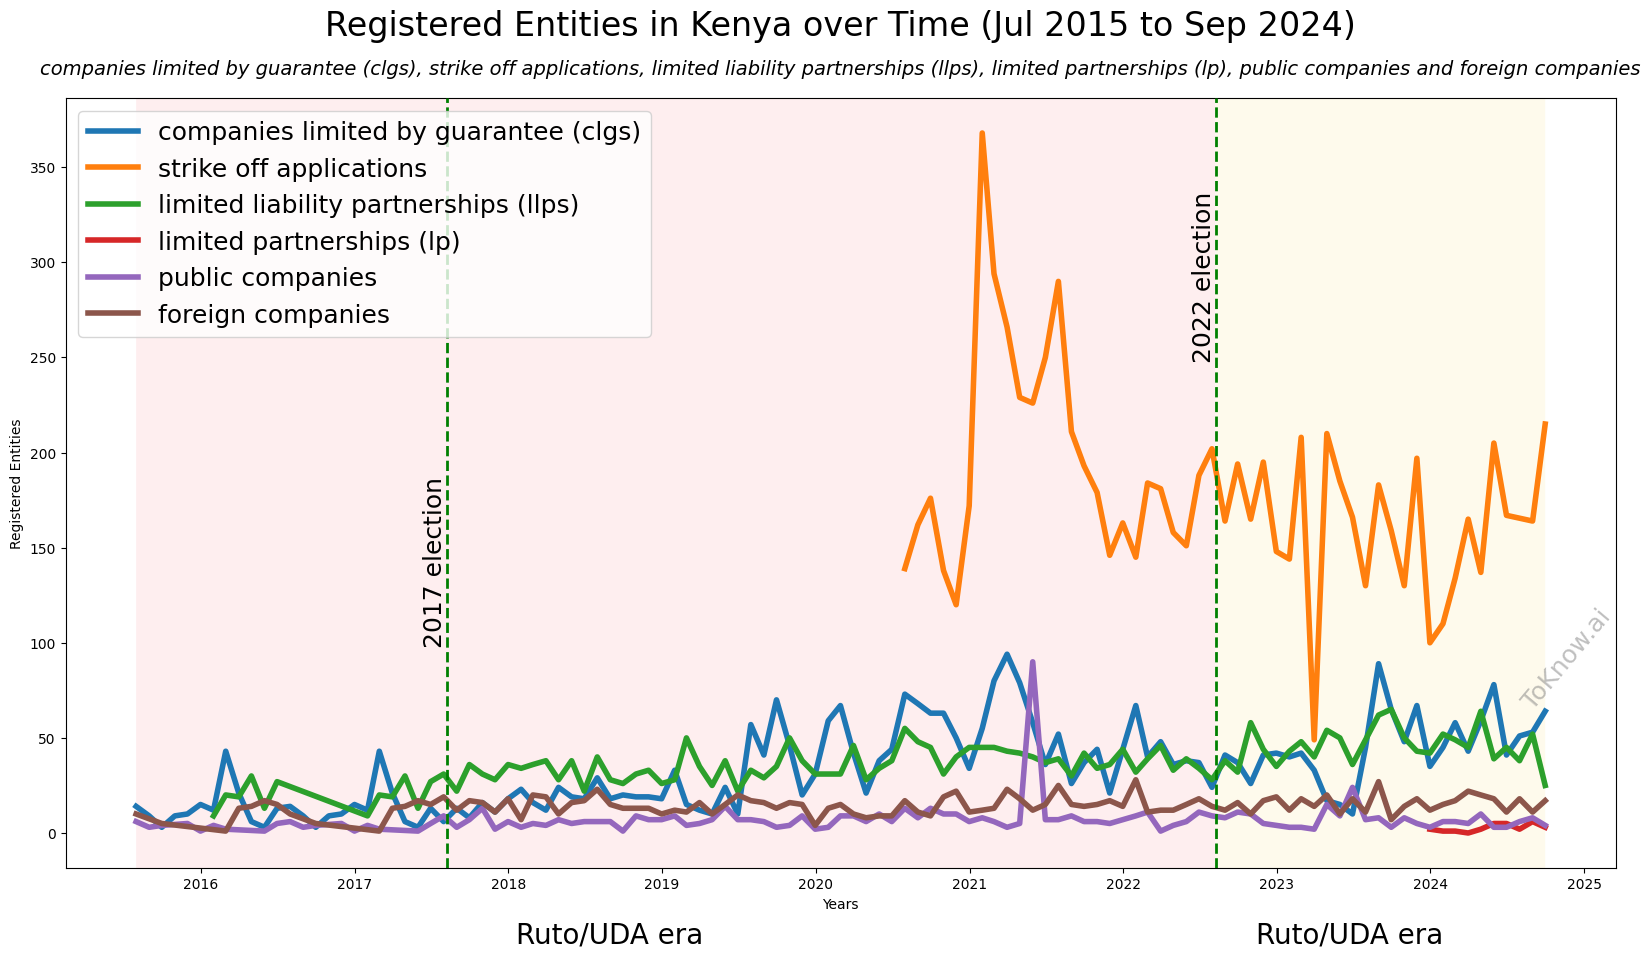

In [6]:
plot_data(
    data_to_plot = [
        all_registrations[[column]].dropna()
        for column 
        in other_plot_columns
    ],
    title_1st_part = 'Registered Entities in Kenya over Time',
    election_dates_y = (100, 250))

This second graph displays the registration trends for other entity
types, including limited partnerships (LP), public companies, foreign
companies, companies limited by guarantee (CLGs), limited liability
partnerships (LLPs), and strike off applications. These registrations
are relatively low, typically less than 500 per month, except for strike
off applications which show a notable increase peaking at around
`2021-01-31`.

### Total Registrations of Entities

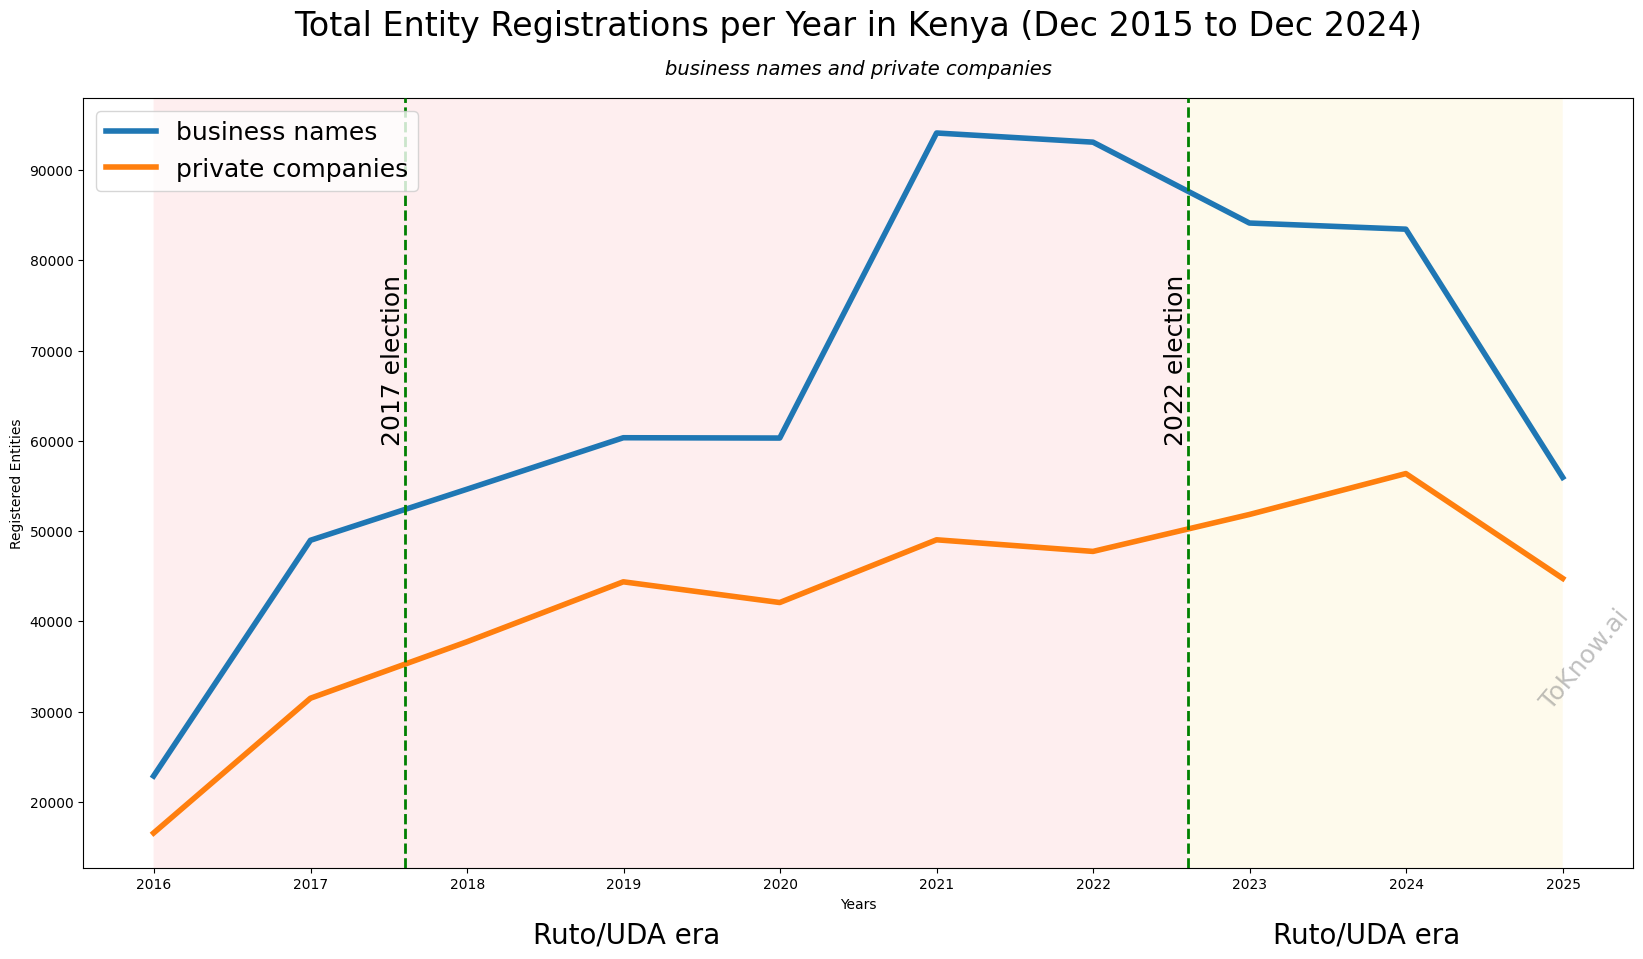

In [7]:
plot_data(
    data_to_plot = 
        all_registrations[plot_columns].dropna().resample('YE').sum().dropna(),
    title_1st_part = 'Total Entity Registrations per Year in Kenya',
    election_dates_y = (60000, 60000))

The annual totals for business names and private companies registrations
reveal:

-   Business names registrations peaked in 2021 before declining.
-   Private companies registrations continued to grow, peaking in early
    2024.

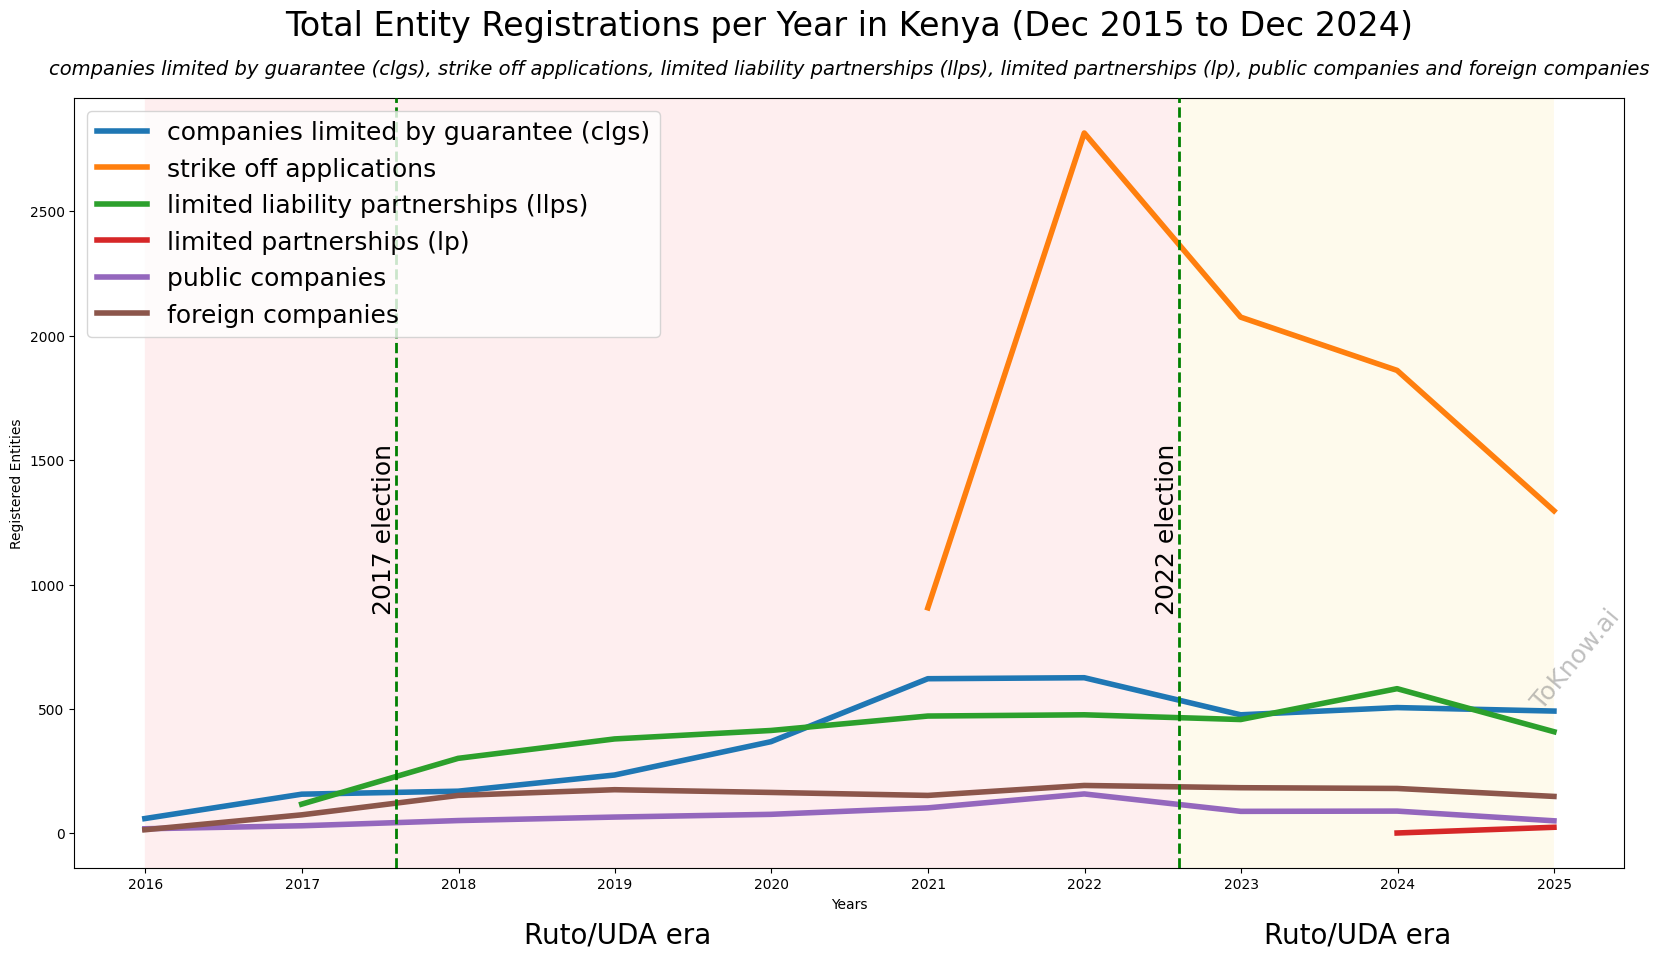

In [8]:
plot_data(
    data_to_plot = [
        all_registrations[[column]].dropna().resample('YE').sum().dropna() 
        for column 
        in other_plot_columns
    ],
    title_1st_part = 'Total Entity Registrations per Year in Kenya',
    election_dates_y = (900, 900))

For other entity types, the annual totals remain relatively low, except
for strike off applications which show a significant increase starting
in 2021, peaking in 2022, and then declining.

### Year-over-Year Growth Rate of Business Entity Registrations

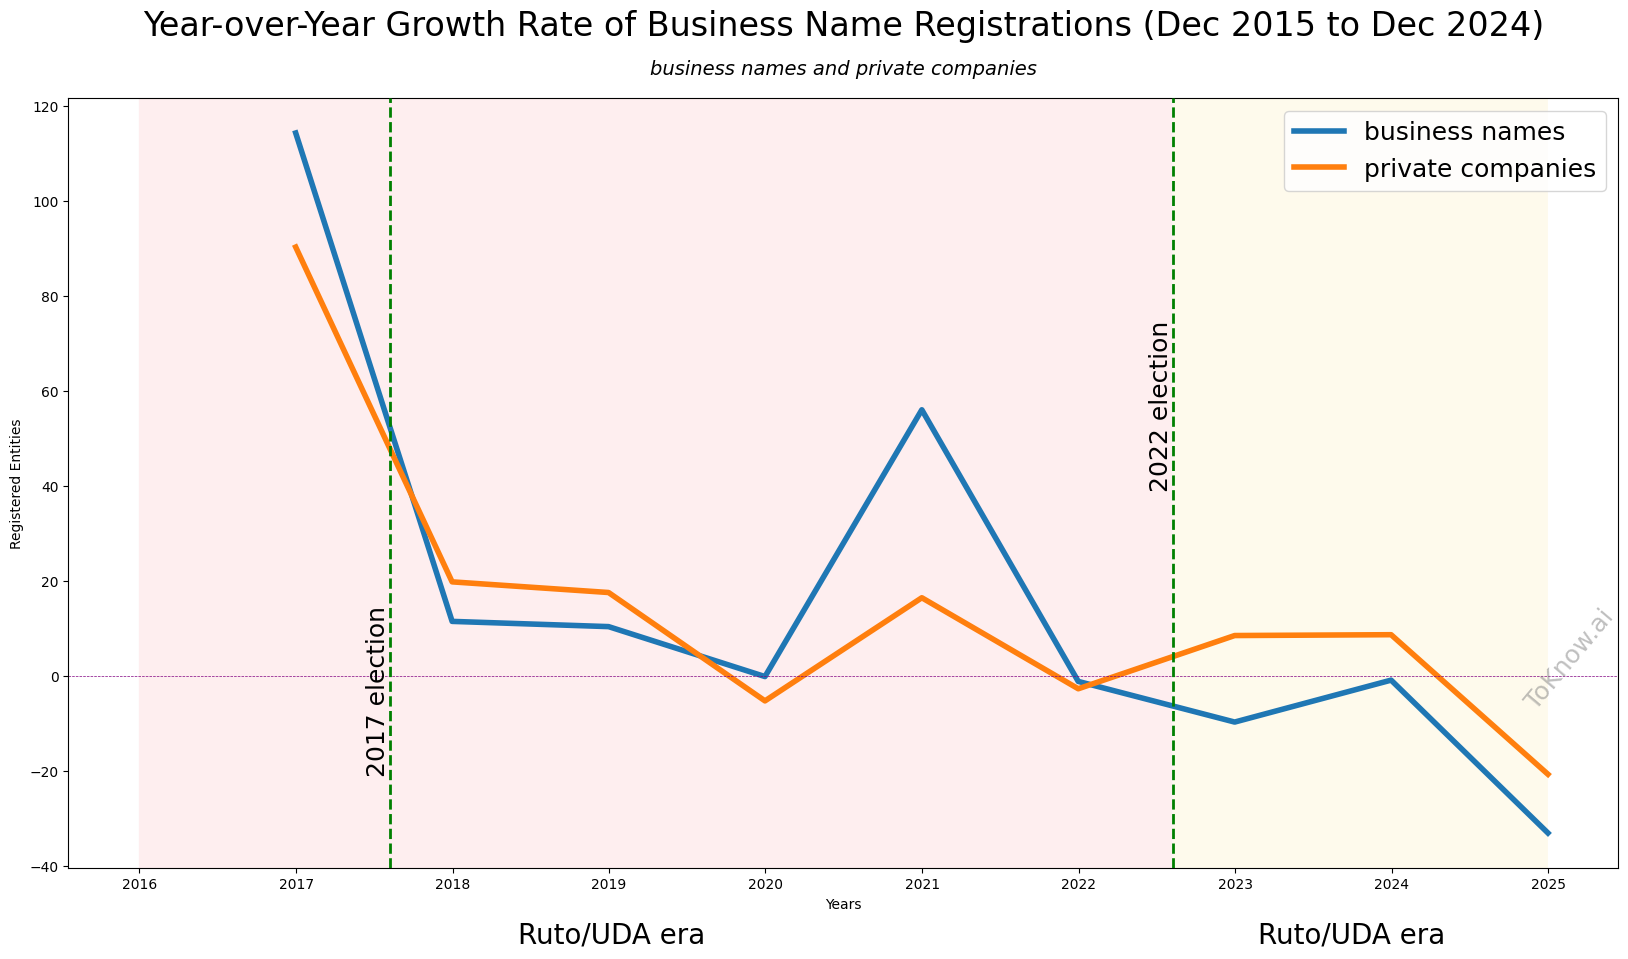

In [9]:
plot_data(
    data_to_plot = all_registrations[plot_columns]
        .dropna().resample('YE').sum().dropna().pct_change() * 100,
    title_1st_part = 'Year-over-Year Growth Rate of Business Name Registrations',
    election_dates_y = (-20, 40),
    legend_loc = 'upper right',
    axis_callback= lambda fig, ax: ax.axhline(
        y=0, color='purple', linestyle='--', linewidth=.5))

The year-over-year growth rates for business names and private companies
show:

-   A generally declining trend in growth rates for both entity types.
-   A brief uptick in growth rates around 2021, followed by a continous
    decline.
-   Negative growth rates in recent years, indicating a contraction in
    new registrations.

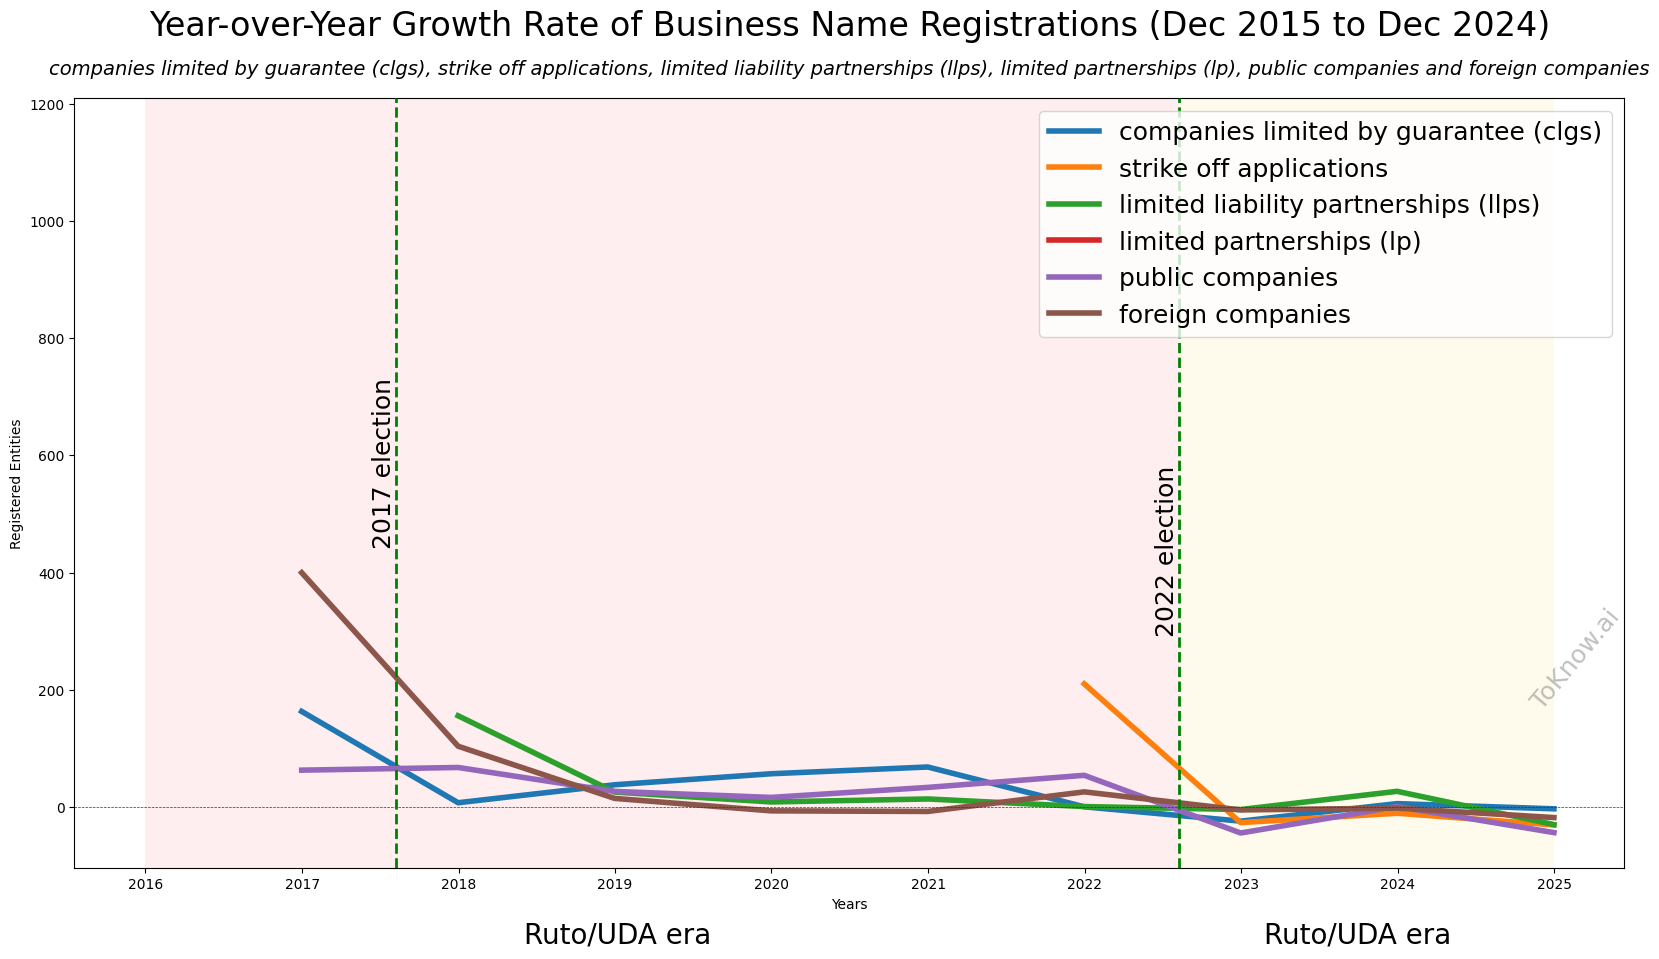

In [10]:
plot_data(
    data_to_plot = [
        all_registrations[[column]]
            .dropna().resample('YE').sum().dropna().pct_change() * 100
        for column 
        in other_plot_columns
    ],
    title_1st_part = 'Year-over-Year Growth Rate of Business Name Registrations',
    election_dates_y = (450, 300),
    legend_loc = 'upper right',
    axis_callback= lambda fig, ax: ax.axhline(
        y=0, color='purple', linestyle='--', linewidth=.5))

Growth rates for other entity types show high volatility due to their
lower numbers, but generally appear to be lower after 2022.

### Trend, Seasonality and Residuals

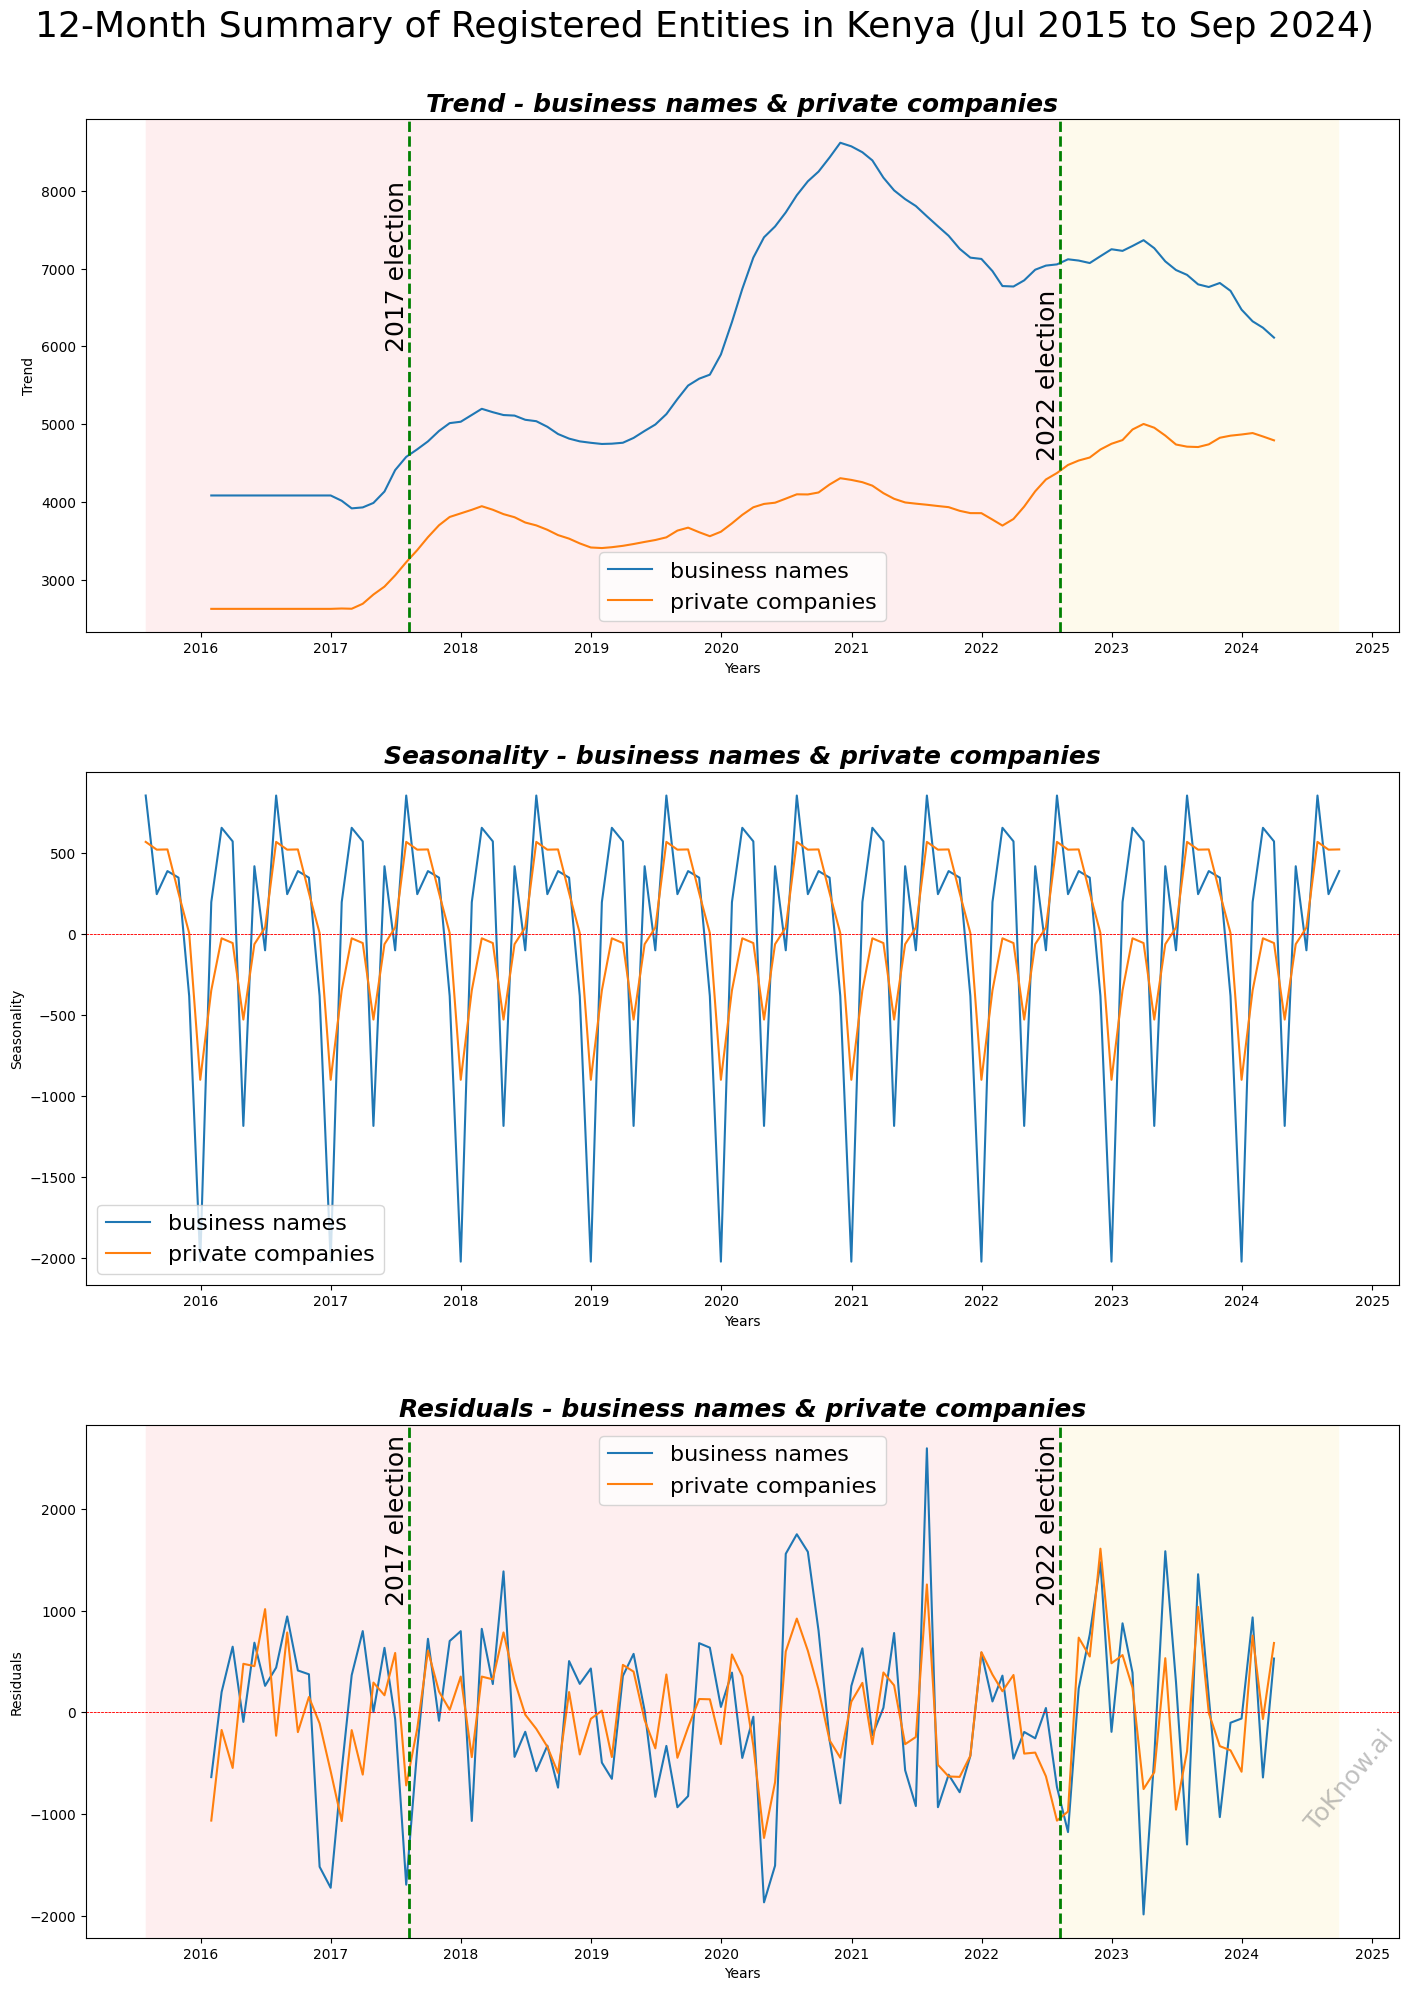

In [11]:
def plot_trend_and_seasonality(
        columns_used: list[str], trend_period = 12, title_wrap: int = None,
        title_args = { 'fontsize': 18, 'fontweight': 'bold', 'fontstyle': 'italic' },
        election_dates_y_trend = (6000, 4600), election_dates_y_resid = (1100, 1100)):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))
    start_date: date = None
    end_date: date = None
    actual_columns_used = []
    for column_used in columns_used:
        plot_series = all_registrations[column_used].dropna()
        if len(plot_series) < 2 * trend_period:
            continue
        actual_columns_used.append(column_used)
        __start_date = min(plot_series.index.date)
        __end_date = max(plot_series.index.date)
        start_date = min(start_date or __start_date, __start_date or start_date)
        end_date = min(end_date or __end_date, __end_date or end_date)
        decomposition = seasonal_decompose(
            plot_series, model='additive', period=trend_period)
        # Plot trend component
        ax1.plot(
            decomposition.trend.index, decomposition.trend.values, label = column_used)
        ax1.set_ylabel('Trend')
        ax1.set_xlabel('Years')
        # Plot seasonal component
        ax2.plot(
            decomposition.seasonal.index, decomposition.seasonal.values, label = column_used)
        ax2.axhline(y=0, color='r', linestyle='--', linewidth=.5)
        ax2.set_ylabel('Seasonality')
        ax2.set_xlabel('Years')
        # Plot residual component
        ax3.plot(
            decomposition.resid.index, decomposition.resid.values, label = column_used)
        ax3.axhline(y=0, color='r', linestyle='--', linewidth=.5)
        ax3.set_ylabel('Residuals')
        ax3.set_xlabel('Years')
    if start_date or end_date:
        draw_election_lines(start_date, end_date, ax1, election_dates_y_trend)
        draw_election_lines(start_date, end_date, ax3, election_dates_y_resid)
        title_template = (
            '{0} - '
            f'{", ".join(actual_columns_used[:-1])} & {actual_columns_used[-1]}'
            if len(actual_columns_used) > 1  else actual_columns_used[0]
        )
        get_title = lambda s1: "\n".join(textwrap.wrap(title_template.format(s1), width=title_wrap)) \
            if title_wrap \
            else title_template.format(s1)
        ax1.set_title(get_title('Trend'), **title_args)
        ax2.set_title(get_title('Seasonality'), **title_args)
        ax3.set_title(get_title('Residuals'), **title_args)
        ax1.legend(fontsize=16)
        ax2.legend(fontsize=16)
        ax3.legend(fontsize=16)
        # Add a watermark to the center of the plot
        ax3.text(
            1, 0.2, 'ToKnow.ai', ha='right', va='bottom', fontsize=18, color='gray', 
            alpha=0.5, transform=ax3.transAxes, rotation=50)
        fig.tight_layout(h_pad=5, pad=4)
        fig.text(
            x = .5, y = 1, fontsize = 26, ha='center',
            s = (
                f'{trend_period}-Month Summary of Registered Entities in Kenya '
                f'({start_date.strftime("%b %Y")} to {end_date.strftime("%b %Y")})'
            ))
    else:
        fig.clear()
        fig.axes.clear()

plot_trend_and_seasonality(plot_columns)

The decomposition of the time series for business names and private
companies reveals:

-   A clear upward trend until 2021, followed by a decline.
-   Strong seasonality, with peaks typically occurring in January-March
    and August.
-   Residuals showing increased volatility in recent years.

------------------------------------------------------------------------

Business names and Private company registrations follow a distinct
seasonal pattern throughout the year:

1.  **January - March**: The year starts with a surge in entrepreneurial
    spirit, peaking around March as people act on their New Year’s
    resolutions.
2.  **April - May**: Registrations decline as initial enthusiasm wanes.
    However, a mid-year rejuvenation occurs in May as people realize the
    year is almost half over.
3.  **June - August**: A new peak emerges in June, followed by a brief
    dip in July. August sees the highest registration numbers of the
    year as people prepare for the final quarter.
4.  **September - December**: A downward trend begins, reaching the
    year’s lowest point in December, likely due to end-of-year
    festivities and holiday preparations.

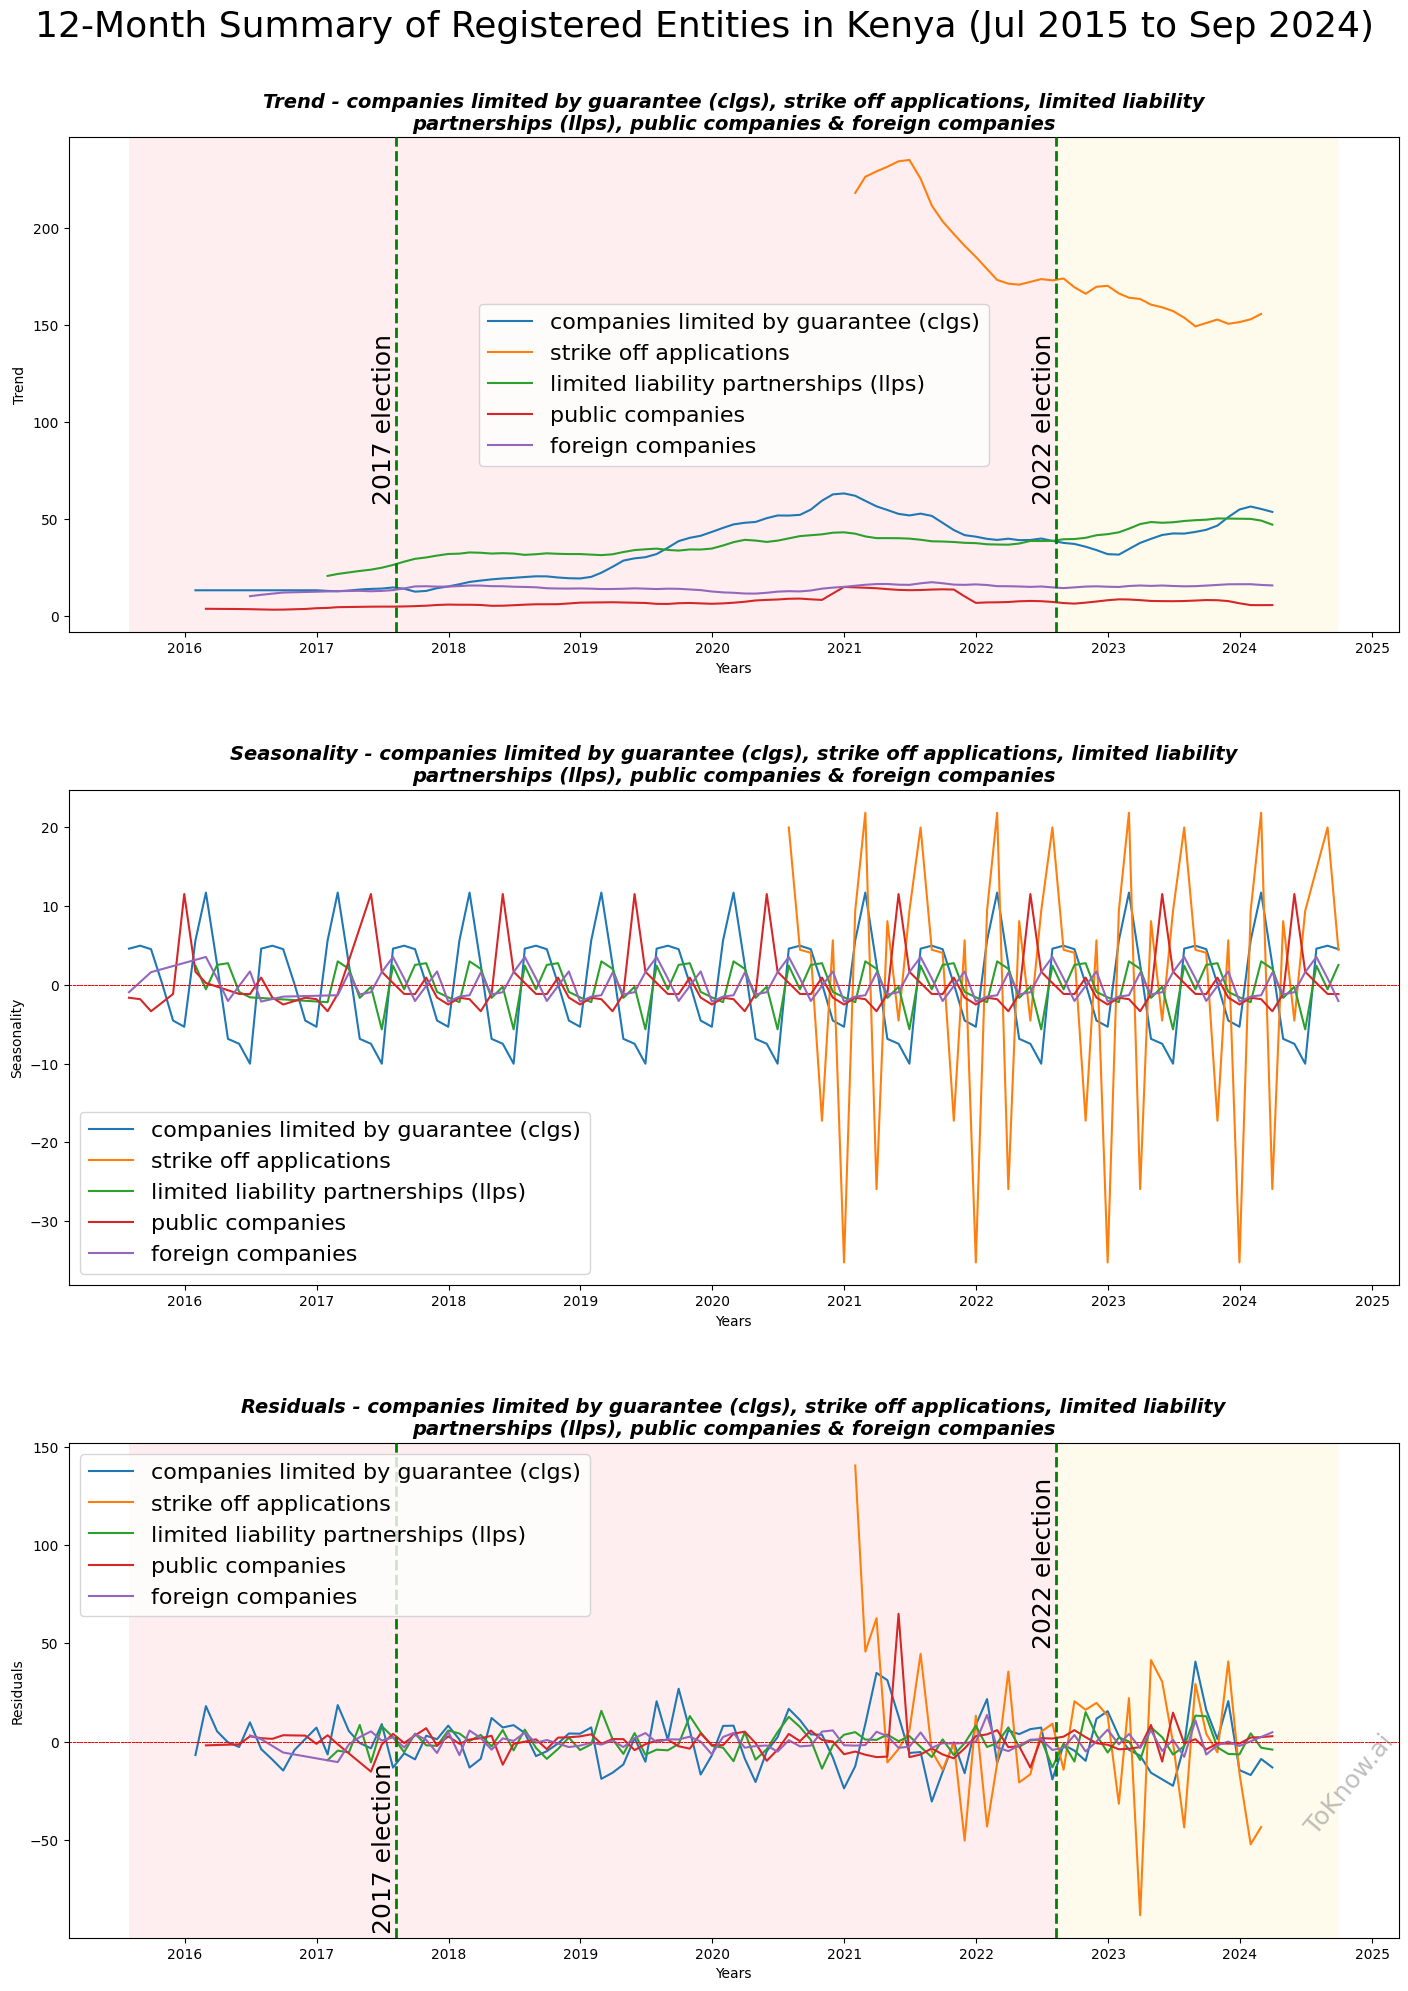

In [12]:
plot_trend_and_seasonality(
    other_plot_columns, title_wrap = 100,
    title_args = { 'fontsize': 14, 'fontweight': 'bold', 'fontstyle': 'italic' },
    election_dates_y_trend = (60, 60), election_dates_y_resid = (-95, 50))

For other entity types, the trends are less pronounced due to lower
numbers, but still show some seasonality and increasing volatility in
residuals over time.

### Interactive Plots

The interative plots are for easier interaction.

In [ ]:
def get_decomposition(
        columns_used: list[str], trend_period = 12, 
        out: dict[Literal['start_date', 'end_date', 'actual_columns_used'], str] = None):
    actual_columns_used = []
    for column_used in columns_used:
        plot_series = all_registrations[column_used].dropna()
        if len(plot_series) < 2 * trend_period:
            continue
        actual_columns_used.append(column_used)
        __start_date = min(plot_series.index.date)
        __end_date = max(plot_series.index.date)
        out['start_date'] = min(out['start_date'] or __start_date, __start_date)
        out['end_date'] = max(out['end_date'] or __end_date, __end_date)
        out['actual_columns_used'].append(column_used)
        yield seasonal_decompose(plot_series, model='additive', period=trend_period), column_used

def draw_election_lines_plotly(start_date, end_date, fig, row, election_dates_y):
    date_list = [
        min(start_date, date(2017, 1, 1)) + timedelta(days=x) 
        for x 
        in range((end_date - start_date).days + 1)
    ]
    election_date_2017 = date(2017, 8, 9)
    election_date_2022 = date(2022, 8, 9)
    # Add vertical lines for election dates
    fig.add_vline(
        x=election_date_2017, line=dict(color='green', width=2, dash='dash'), row=row, col=1)
    fig.add_vline(
        x=election_date_2022, line=dict(color='green', width=2, dash='dash'), row=row, col=1)
    # Add colored regions
    fig.add_vrect(x0=min(date_list), x1=election_date_2022, fillcolor='#f62f3c', 
                  opacity=0.08, layer='below', line_width=0, row=row, col=1)
    fig.add_vrect(x0=election_date_2022, x1=max(date_list), fillcolor='#f8c811', 
                  opacity=0.08, layer='below', line_width=0, row=row, col=1)
    # Add text annotations for election dates
    fig.add_annotation(x=election_date_2017, y=election_dates_y[0], text='2017 election', 
                       textangle=-90, font=dict(size=18), showarrow=False, xanchor='right', 
                       row=row, col=1)
    fig.add_annotation(x=election_date_2022, y=election_dates_y[1], text='2022 election', 
                       textangle=-90, font=dict(size=18), showarrow=False, xanchor='right', 
                       row=row, col=1)

def interactive_plot(
        columns_used: list[str], trend_period = 12,
        election_dates_y_trend = (6000, 4600), election_dates_y_resid = (1500, 1200)):
    subplot_titles = ['Summary Trend', 'Summary Seasonality', 'Summary Residuals']
    fig = make_subplots(rows=3, cols=1, vertical_spacing=0.1, subplot_titles=subplot_titles,
        shared_xaxes=True, figure=go.Figure(layout=go.Layout(height=1200)))
    out = {
        'start_date': None,
        'end_date': None,
        'actual_columns_used': []
    }
    for (decomposition, column_used), color_used in zip(
        get_decomposition(columns_used, trend_period, out), px.colors.qualitative.Plotly[3:]):
        column_used_name = '<br>'.join(textwrap.wrap(column_used, width=20))
        # Plot trend component
        fig.add_trace(go.Scatter(
            x=decomposition.trend.index, y=decomposition.trend.values, mode='lines', 
            name=column_used, legendgroup=column_used, showlegend=True, 
            line=dict(color=color_used)), row=1, col=1)
        # Plot seasonal component
        fig.add_trace(go.Scatter(
            x=decomposition.seasonal.index, y=decomposition.seasonal.values, mode='lines', 
            name=column_used, legendgroup=column_used, showlegend=False, 
            line=dict(color=color_used)), row=2, col=1)
        fig.add_hline(y=0, line=dict(color='red', width=0.5, dash='dash'), row=2, col=1)
        # Plot residual component
        fig.add_trace(go.Scatter(
            x=decomposition.resid.index, y=decomposition.resid.values, mode='lines', 
            name=column_used, legendgroup=column_used, showlegend=False, 
            line=dict(color=color_used)), row=3, col=1)
        fig.add_hline(y=0, line=dict(color='red', width=0.5, dash='dash'), row=3, col=1)
    start_date = out['start_date']
    end_date = out['end_date']
    if start_date:
        draw_election_lines_plotly(start_date, end_date, fig, 1, election_dates_y_trend)
        draw_election_lines_plotly(start_date, end_date, fig, 3, election_dates_y_resid)
        fig.update_layout(
            title=dict(
                text=(
                    f'{trend_period}-Month Summary of Registered Entities in Kenya'
                    f' ({start_date.strftime("%b %Y")} to {end_date.strftime("%b %Y")})'
                    '<br>'
                    'Trend - Seasonality - Residuals'
                ),
                font=dict(size=26),
                x=0.5,
                xanchor='center',
                y = 0.95,
                yanchor = 'top',
            ),
            showlegend=True,
            legend=dict(font=dict(size=16)),
        )
        fig.add_annotation(
            text="ToKnow.ai",
            x=1,
            y=0.25,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=50, color="lightgrey"),
            opacity=0.5,
            textangle=-30)
        fig.update_layout(
            margin=dict(t=140),
            legend=dict(
                orientation="h", yanchor="bottom", y=-0.2, xanchor="center", x=0.5))
    fig.update_xaxes(showticklabels=True, title_text="Years", row=1, col=1)
    fig.update_xaxes(showticklabels=True, title_text="Years", row=2, col=1)
    fig.update_xaxes(showticklabels=True, title_text="Years", row=3, col=1)
    fig.update_yaxes(title_text="Trend", row=1, col=1)
    fig.update_yaxes(title_text="Seasonality", row=2, col=1)
    fig.update_yaxes(title_text="Residuals", row=3, col=1)
    return fig

interactive_plot(plot_columns + other_plot_columns)

### Archiving the Data

The dataset has been archived at
<https://huggingface.co/datasets/ToKnow-ai/Summary-of-Registered-Entities-and-Companies-in-Kenya>

## Key Findings

1.  **Dominance of Business Names and Private Companies**: These two
    categories consistently outpace other forms of registration,
    indicating a preference for simpler business structures among Kenyan
    entrepreneurs.

2.  **Transition Between Political Eras**:

    -   The Uhuru/Jubilee era (pre-2022) showed a general upward trend
        in registrations, particularly for business names and private
        companies.
    -   The early Ruto/UDA era (post-2022) exhibits some volatility in
        registration numbers, with a slight downward trend observable in
        some categories.

3.  **Resilience of the Entrepreneurial Spirit** Despite political
    transitions and global events (such as the COVID-19 pandemic, which
    falls within this period), the overall trend of business
    registrations remains positive. This suggests a robust
    entrepreneurial spirit in Kenya that persists through various
    challenges.

4.  **Seasonal Patterns**: Business registrations tend to peak in the
    first quarter of the year (January-March) and again in August,
    possibly reflecting fiscal year planning.

5.  **Rise in Strike Off Applications**: There’s a notable increase in
    strike off applications starting in 2021, which could indicate
    economic stress or regulatory changes affecting business closures.

6.  **Slowdown in Growth**: Recent years show a slowdown in the growth
    rate of new business registrations, particularly after 2021, which
    may reflect broader economic challenges.

## Conclusion

This analysis of Kenya’s business registration trends offers a unique
window into the country’s economic dynamics and the interplay between
politics and entrepreneurship. While political transitions and global
events like the COVID-19 pandemic have impacted business formation, the
overall trend suggests a resilient formal business sector in Kenya.

As Kenya continues to position itself as a key economic player in East
Africa, understanding these trends can be crucial for policymakers,
investors, and entrepreneurs alike. Future research could delve deeper
into sector-specific trends or compare Kenya’s patterns with those of
neighboring countries to provide a more comprehensive regional
perspective.

------------------------------------------------------------------------

***Disclaimer:*** *For information only. Accuracy or completeness not
guaranteed. Illegal use prohibited. Not professional advice or
solicitation.* ***Read more:
[/terms-of-service](https://toknow.ai/terms-of-service)***